In [60]:
import torch
from transformers import BeitFeatureExtractor, BeitForImageClassification
from torch.utils.data import random_split, DataLoader

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

from dataset import SingleImageDataset, FullLocationDataset
from Haversine import HaversineLoss, haversine_distance

In [18]:
feature_extractor = BeitFeatureExtractor.from_pretrained('microsoft/beit-base-patch16-384')
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-384').to("cuda")

model.classifier = torch.nn.Linear(768, 2).to("cuda")

c:\Users\erena\anaconda3\envs\Torch-DL\Lib\site-packages\transformers\models\beit\feature_extraction_beit.py:28: FutureWarning: The class BeitFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use BeitImageProcessor instead.
  warnings.warn(


In [120]:
checkpoint = torch.load("../models/model_epoch_14.pt")

checkpoint.keys()

dict_keys(['epoch', 'model_state_dict', 'best_val_loss', 'train_losses', 'val_losses', 'train_haversine', 'val_haversine'])

In [122]:
checkpoint['val_losses']

[0.503051878458046,
 0.4315063335809363,
 0.40169797245278416,
 0.4044312845511609,
 0.37819544881223194,
 0.38413891375782977,
 0.37175985093576364,
 0.3865430875715003,
 0.3796376837305276,
 0.36982725219554213,
 0.3771795199578067,
 0.373352615948183,
 0.36863534278180227,
 0.3725180137588317]

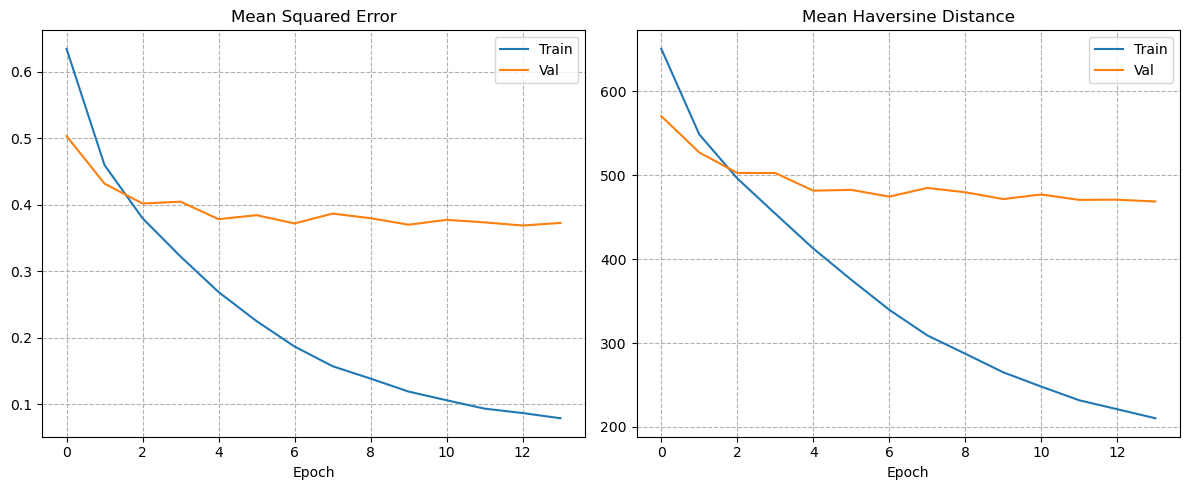

In [121]:
train_losses = checkpoint['train_losses']
val_losses = checkpoint['val_losses']
train_haversine = checkpoint['train_haversine']
val_haversine = checkpoint['val_haversine']

fig, ax = plt.subplots(ncols=2, figsize=(12, 5))

ax[0].plot(train_losses, label="Train")
ax[0].plot(val_losses, label='Val')
ax[0].set_title("Mean Squared Error")

ax[1].plot(train_haversine, label="Train")
ax[1].plot(val_haversine, label="Val")
ax[1].set_title("Mean Haversine Distance")

for a in ax:
    a.set_xlabel("Epoch")
    a.grid(ls='--')
    a.legend()

fig.tight_layout()

In [123]:
model.load_state_dict(checkpoint['model_state_dict'])

model.eval()

for param in model.parameters():
    param.requires_grad = False

In [20]:
torch.manual_seed(42)

dataset = SingleImageDataset()

train_set, _, test_set = random_split(dataset, [0.6, 0.2, 0.2])

# train_loader = DataLoader(train_set, batch_size=128, num_workers=4, shuffle=True)
test_loader = DataLoader(test_set, batch_size=32, num_workers=2, shuffle=False, pin_memory=True)

In [23]:
criterion = torch.nn.MSELoss()
haversine_metric = HaversineLoss()

In [22]:
MEAN_LAT = 45.65404757
MEAN_LON = 7.95102084
STD_LAT = 4.644684882
STD_LON = 9.326391596

def standardizeLabels(labels):
    latitudes = labels[:, 0]
    longtitudes = labels[:, 1]

    latitudes = (latitudes - MEAN_LAT) / STD_LAT
    longtitudes = (longtitudes - MEAN_LON) / STD_LON

    labels[:, 0] = latitudes
    labels[:, 1] = longtitudes

    return labels


def unstandardizeLabels(labels):
    latitudes = labels[:, 0]
    longtitudes = labels[:, 1]

    latitudes = latitudes * STD_LAT + MEAN_LAT
    longtitudes = longtitudes * STD_LON + MEAN_LON

    labels[:, 0] = latitudes
    labels[:, 1] = longtitudes

    return labels

In [21]:
n = 0
sum_lon = 0
sum_lat = 0
sum_sq_lon = 0
sum_sq_lat = 0

for _, labels in tqdm(train_loader):
    latitudes = labels[:, 0].detach()
    longtitudes = labels[:, 1].detach()

    n += latitudes.nelement()
    sum_lon += longtitudes.sum().item()
    sum_lat += latitudes.sum().item()
    sum_sq_lon += torch.pow(longtitudes, 2).sum().item()
    sum_sq_lat += torch.pow(latitudes, 2).sum().item()

  0%|          | 0/248 [00:00<?, ?it/s]

In [22]:
mean_lon = sum_lon / n
mean_lat = sum_lat / n

var_lon = (sum_sq_lon - sum_lon**2 / n) / (n - 1)
var_lat = (sum_sq_lat - sum_lat**2 / n) / (n - 1)

mean_lon, mean_lat, var_lon, var_lat

(7.951020843814118, 45.654047571047386, 86.98158021195114, 21.573097655562876)

In [23]:
var_lon**0.5, var_lat**0.5

(9.326391596536741, 4.6446848822673505)

In [124]:
test_loss_batches = []
test_haversine_batches = []

for images, labels in tqdm(test_loader):
    with torch.no_grad():
        model.eval()
        labels = labels.cuda(non_blocking=True)
        labels = standardizeLabels(labels)

        features = feature_extractor(images, return_tensors="pt")
        features = features['pixel_values'].cuda(non_blocking=True)

        y_pred = model(features)

        loss = criterion(y_pred.logits, labels)
        test_loss_batches.append(loss.item())
        
        distance = haversine_metric(unstandardizeLabels(y_pred.logits.detach()), unstandardizeLabels(labels)).item()
        test_haversine_batches.append(distance)

  0%|          | 0/330 [00:00<?, ?it/s]

In [125]:
mean_loss = np.mean(test_loss_batches)
mean_haversine = np.mean(test_haversine_batches)

mean_loss, mean_haversine

(0.3762121574445204, 470.779965949781)

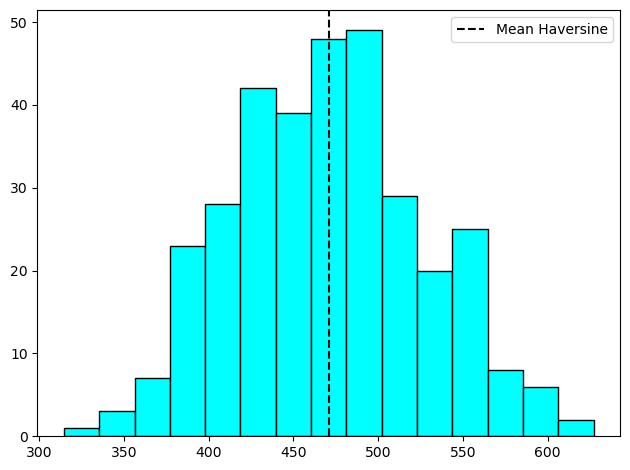

In [126]:
fig, ax = plt.subplots()

ax.hist(test_haversine_batches, edgecolor='black', bins=15, color='cyan')

ax.axvline(mean_haversine, ls='--', color='black', label='Mean Haversine')

ax.legend()

fig.tight_layout()

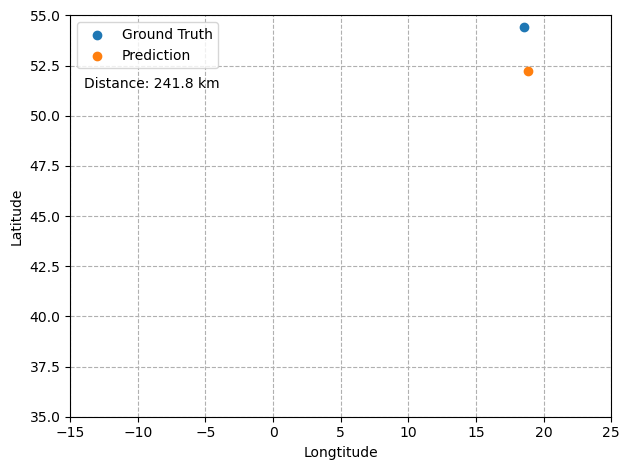

In [155]:
POINT = 21

lon1, lat1 = labels[POINT, 1].cpu(), labels[POINT,0].cpu()
lon2, lat2 = y_pred.logits[POINT,1].cpu(), y_pred.logits[POINT,0].cpu()

distance_between = haversine_distance(lat1, lon1, lat2, lon2)

fig, ax = plt.subplots()

ax.scatter(lon1, lat1, label="Ground Truth", zorder=2)
ax.scatter(lon2, lat2, label="Prediction", zorder=2)

ax.annotate(f"Distance: {distance_between:.1f} km", xy=(0.025, 0.82), xycoords='axes fraction', zorder=2)

ax.set_ylabel("Latitude")
ax.set_xlabel("Longtitude")

ax.legend(loc=2)

ax.set_xlim(-15, 25)
ax.set_ylim(35, 55)

ax.grid(ls='--', zorder=0)

fig.tight_layout()

In [180]:
import geopandas as gpd

In [158]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']

C:\Users\erena\AppData\Local\Temp\ipykernel_16188\1739138963.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


In [209]:
points = [3, 4, 5, 6, 8, 20, 22, 29, 30]

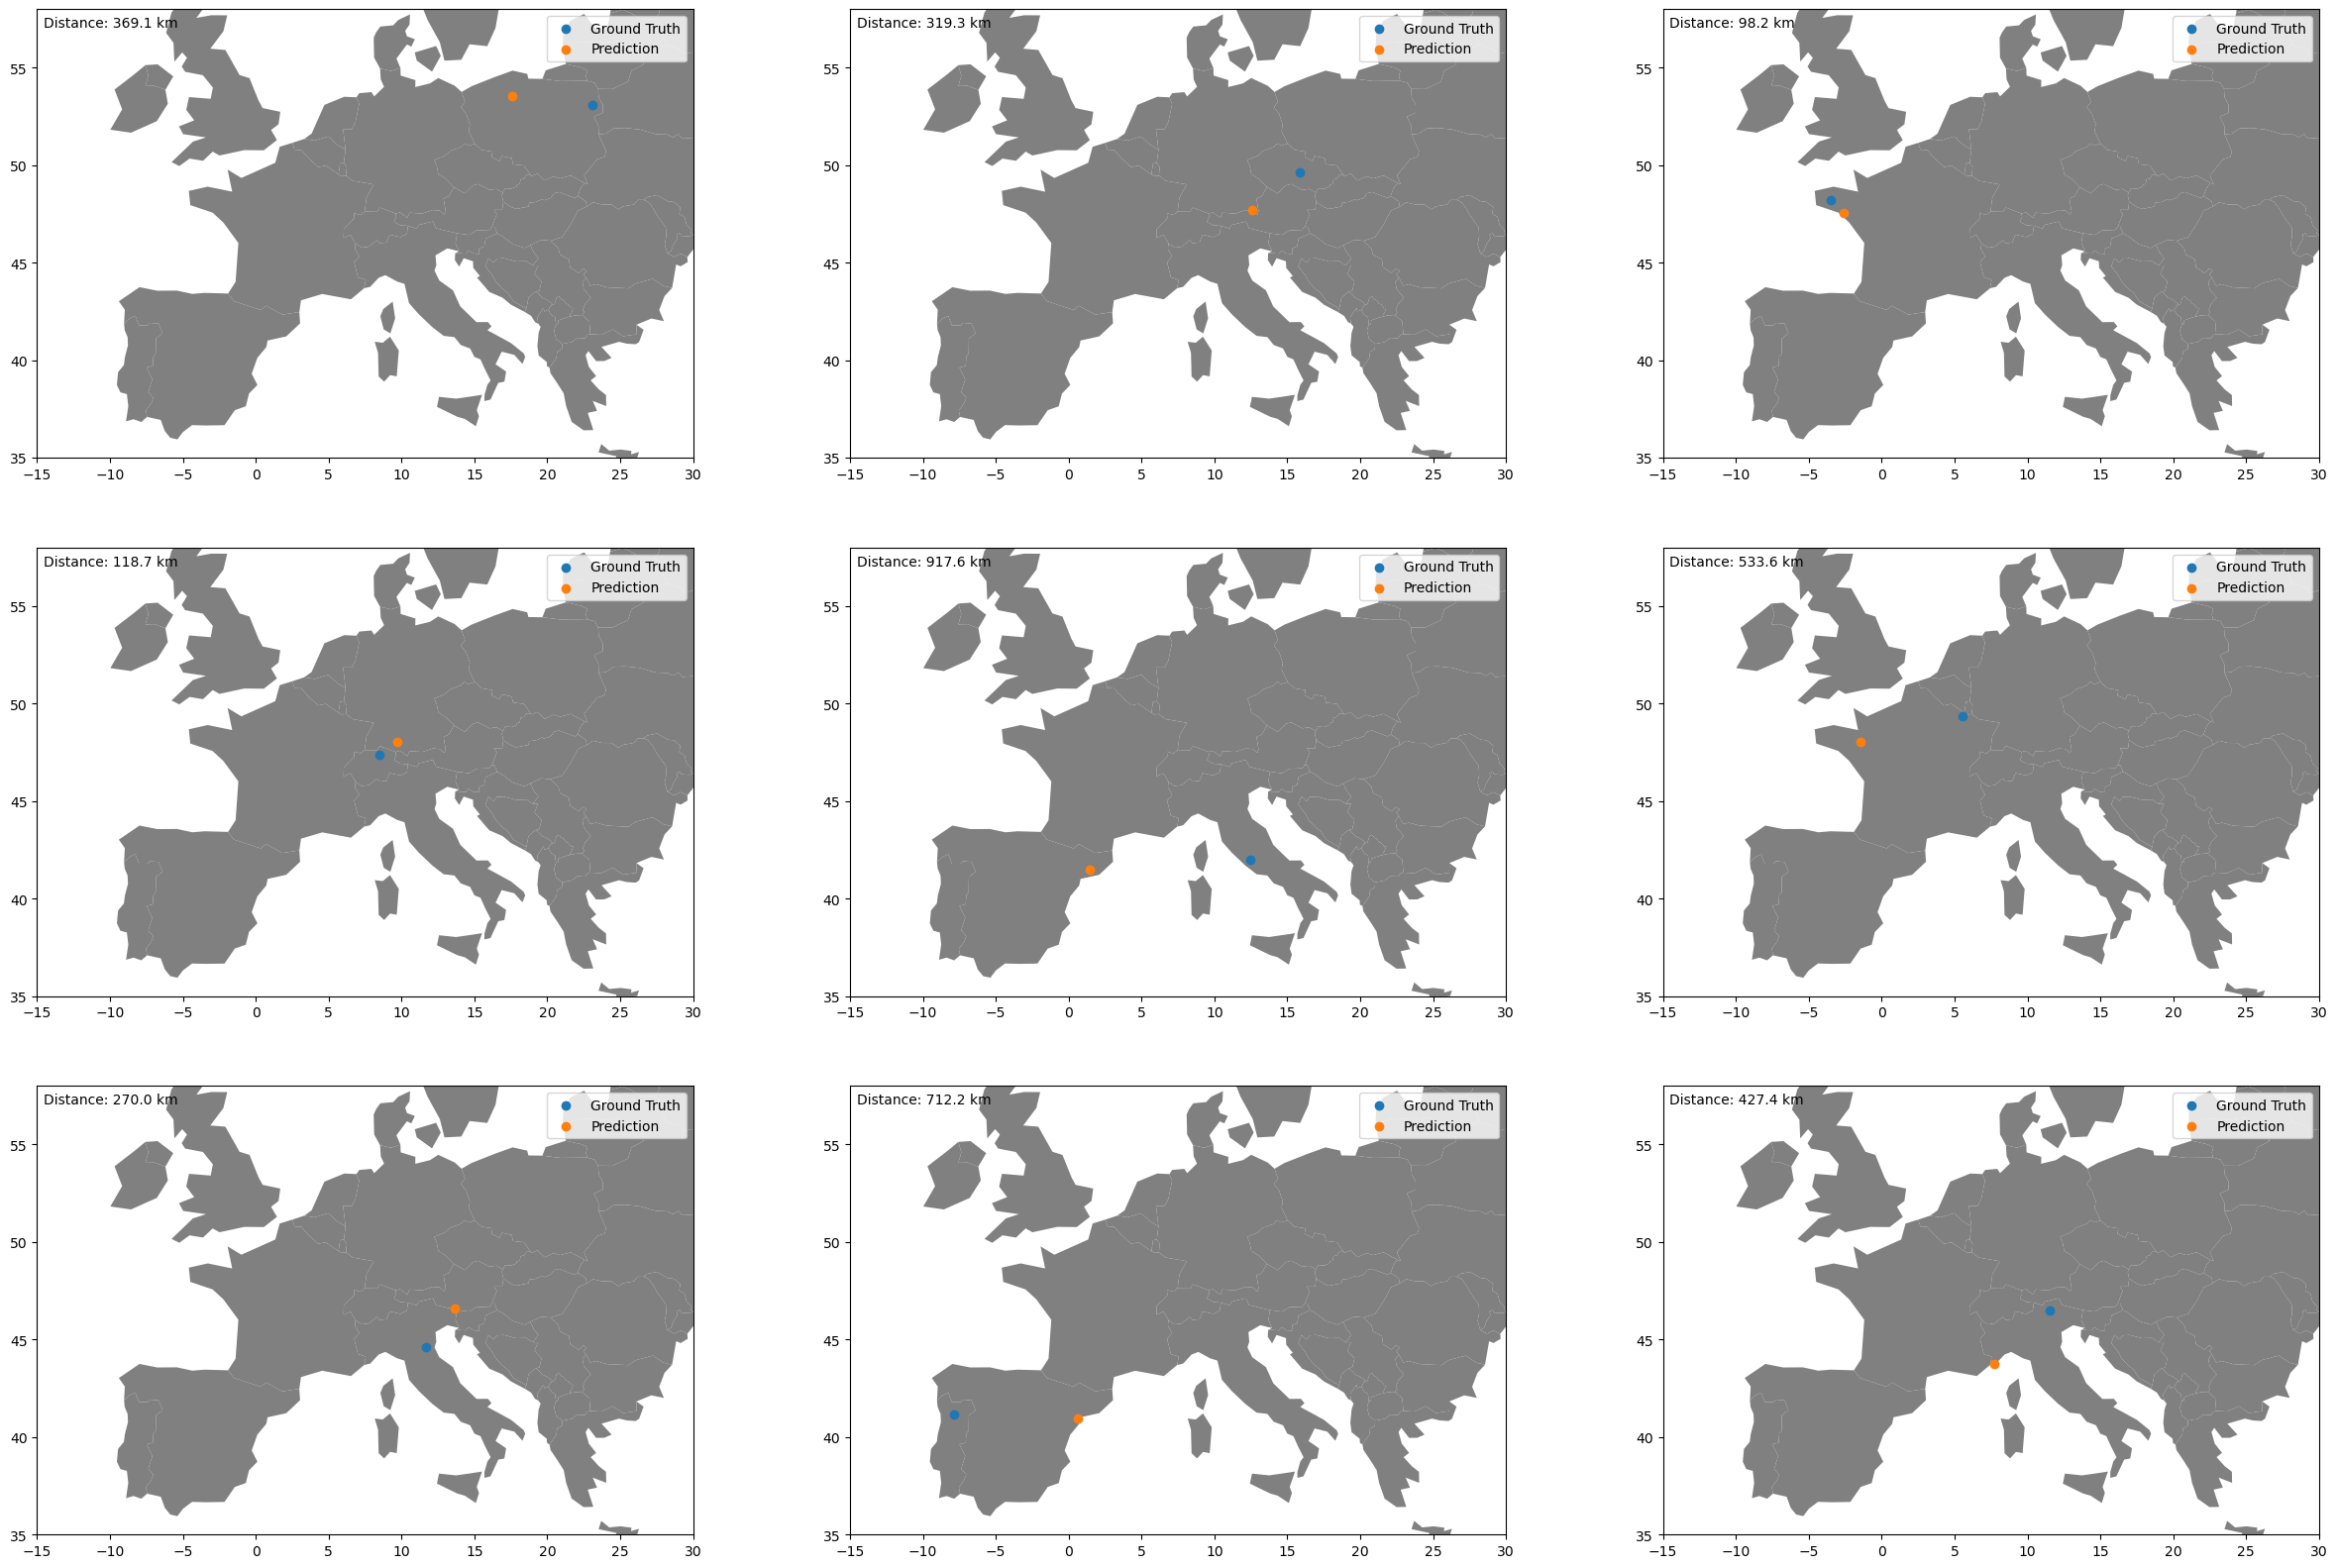

In [227]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(30, 20))

for i, point in enumerate(points):
    lon1, lat1 = labels[point, 1].cpu(), labels[point,0].cpu()
    lon2, lat2 = y_pred.logits[point,1].cpu(), y_pred.logits[point,0].cpu()
    distance_between = haversine_distance(lat1, lon1, lat2, lon2)

    europe.plot(ax=ax[i//3][i%3], color='grey')
    ax[i//3][i%3].scatter(lon1, lat1, label="Ground Truth", zorder=2)
    ax[i//3][i%3].scatter(lon2, lat2, label="Prediction", zorder=2)
    ax[i//3][i%3].annotate(f"Distance: {distance_between:.1f} km", xy=(0.01, 0.96), xycoords='axes fraction', zorder=2)
    ax[i//3][i%3].legend()

    ax[i//3][i%3].set_xlim(-15, 30)
    ax[i//3][i%3].set_ylim(35, 58)

fig.savefig("../figures/predictions.pdf")